# Coreset algorithm on fMRI

In [ ]:
import webdataset as wds 
import random
import torch
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

from qpsolvers import solve_qp

def my_split_by_node(urls): return urls

f = h5py.File(f'/weka/home-alexnguyen/mindeyev2_dataset/betas_all_subj01_fp32.hdf5', 'r')
voxels = f['betas'][:]
del f 
print (voxels.shape)
def filter_samples_func(sample):
    # return sample 
    if sample["behav.npy"][0,7] != 0:
        return None
    return sample

train_url = "/weka/home-alexnguyen/mindeyev2_dataset/wds/subj01/new_train/{0..39}.tar"
train_data = wds.WebDataset(train_url,resampled=True,nodesplitter=my_split_by_node)\
                        .shuffle(750, initial=2500, rng=random.Random(1))\
                        .decode("torch").map(filter_samples_func)\
                       .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                       .to_tuple(*["__key__", "behav", "past_behav", "future_behav", "olds_behav"]) 
train_dl = torch.utils.data.DataLoader(train_data, batch_size=512, shuffle=False, drop_last=True, pin_memory=True) 
keys = set() 
for iter, (key, behav0, past_behav0, future_behav0, old_behav0) in enumerate(train_dl): 
    
#     print (behav0[:,0,0].cpu().long())
#     print (past_behav0[:,0,0].cpu().long())
    [keys.add( i.item() ) for i in behav0[:,0,5].cpu().long()]
    if iter % 10 == 1: print (len(keys))
    if len(keys) >= 27000: break

In [ ]:
# get voxels using keys
keys = list(keys)
_voxels = voxels[keys]
# convert to numpy
print (_voxels.shape)

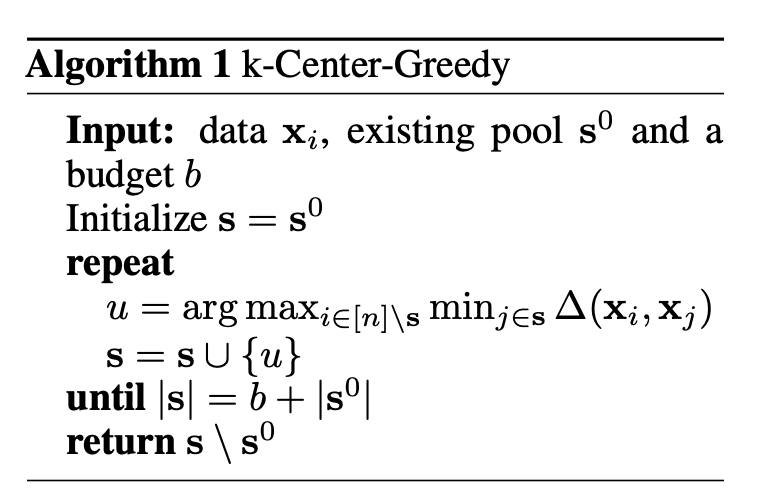

In [ ]:
def make_coreset(_voxels,seed):
    idxs = []
    voxel_ids = []  
    _voxels = torch.Tensor(_voxels).to('cuda:0')
    pdist = torch.nn.PairwiseDistance(p=2,keepdim=True)
    # fill with infinity
    
    for i in range(len(_voxels)):
        if len(idxs) == 0:
            idxs.append(np.random.choice(len(_voxels), 1).item())
            voxel_ids.append(keys[idxs[0]])
            already_selected_voxels = _voxels[idxs].unsqueeze(0) # get selected voxels 
            dist = torch.cdist(_voxels.unsqueeze(0), already_selected_voxels).squeeze(0) 
            min_dist = torch.min(dist, dim=1).values
            print (dist.shape, min_dist.shape, min_dist, "chose", len(idxs), "items")
            continue 
        argmax = torch.argmax(min_dist)
        assert argmax not in idxs, "Error, already selected"
        # print (argmax, min_dist.shape, min_dist[argmax])
        idxs.append(argmax.item()) # add to selected 
        voxel_ids.append(keys[argmax]) # add to selected
        
        selected_voxels = _voxels[argmax].unsqueeze(0).unsqueeze(1) # get selected voxels 
        dist = torch.cdist(_voxels.unsqueeze(0), selected_voxels).flatten()
        # print ("d",dist.shape,min_dist.shape)
        min_dist = torch.minimum(dist, min_dist)
        if len(voxel_ids) in [750, 1500, 2250, 3000, 6000, 9000, 12000, 15000, 18000, 21000, 24000, 27000]:
            print (len(idxs))
            np.save(f"./cache/fmriraw_coreset_pruned_ids_N_{int(len(voxel_ids))}_seed_{seed}.npy", voxel_ids)
        
make_coreset(_voxels,seed=1)
make_coreset(_voxels,seed=2)
make_coreset(_voxels,seed=3)
make_coreset(_voxels,seed=4)


# Coreset algorithm on CLIP

In [ ]:
import webdataset as wds 
import random
import torch
import h5py
import numpy as np
import matplotlib.pyplot as plt
from qpsolvers import solve_qp

def my_split_by_node(urls): return urls
 

f = h5py.File(f'/weka/home-alexnguyen/mindeyev2_dataset/coco_images_224_float16.hdf5', 'r')
images = f['images'][:]
images = torch.Tensor(images).to("cpu") 
del f 
print (images.shape)

train_url = "/weka/home-alexnguyen/mindeyev2_dataset/wds/subj01/new_train/{0..39}.tar"
train_data = wds.WebDataset(train_url,resampled=True,nodesplitter=my_split_by_node)\
                        .shuffle(750, initial=2500, rng=random.Random(1))\
                        .decode("torch")\
                       .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                       .to_tuple(*["__key__", "behav", "past_behav", "future_behav", "olds_behav"]) 
train_dl = torch.utils.data.DataLoader(train_data, batch_size=512, shuffle=False, drop_last=True, pin_memory=True) 
keys = set() 
for iter, (key, behav0, past_behav0, future_behav0, old_behav0) in enumerate(train_dl): 
    

    # print ("Behav, pastbehav", behav0[:10,0,0].cpu().long(), past_behav0[:10,0,0].cpu().long())
    first_image_presentation_id = past_behav0[:,-1,5].cpu().long() 
    # print ("past_behavior", past_behavior )
    # [keys.add( i.item() ) for i in behav0[:,0,0].cpu().long()]
    [keys.add( i.item() ) for i in past_behavior]
    print (len(keys))
    if iter % 20 == 1: 
        print (len(keys), past_behav0.shape)
    # if len(keys) >= 9000: break

In [ ]:
keys

# Toy data

In [ ]:
idxs = []
voxel_ids = []
# _voxels = torch.randn(1000, 2)
# _voxels = np.random.rand(1000, 2)
from sklearn.datasets import make_blobs 
_voxels, _ = make_blobs(n_samples=1000, centers=10, n_features=2, random_state=0,
                            cluster_std= np.abs(np.random.randn(10) + 1e-3) * 3)
plt.scatter(_voxels[:,0], _voxels[:,1])
plt.show()
keys = torch.arange(1000)
_voxels = torch.Tensor(_voxels).to('cuda:0')
pdist = torch.nn.PairwiseDistance(p=2,keepdim=True)
# fill with infinity

for i in range(len(_voxels)):
    if len(idxs) == 0:
        idxs.append(np.random.choice(len(_voxels), 1).item())
        voxel_ids.append(keys[idxs[0]])
        already_selected_voxels = _voxels[idxs].unsqueeze(0) # get selected voxels 
        dist = torch.cdist(_voxels.unsqueeze(0), already_selected_voxels).squeeze(0) 
        min_dist = torch.min(dist, dim=1).values
        print (dist.shape, min_dist.shape, min_dist, "chose", len(idxs), "items")
        continue 
    argmax = torch.argmax(min_dist)
    assert argmax not in idxs, "Error, already selected"
    print (argmax, min_dist.shape, min_dist[argmax])
    idxs.append(argmax.item()) # add to selected 
    voxel_ids.append(keys[argmax]) # add to selected
    print (len(idxs))
    selected_voxels = _voxels[argmax].unsqueeze(0).unsqueeze(1) # get selected voxels 
    dist = torch.cdist(_voxels.unsqueeze(0), selected_voxels).flatten()
    # print ("d",dist.shape,min_dist.shape)
    min_dist = torch.minimum(dist, min_dist)
    # print ("selected_voxels.shape",selected_voxels.shape,  "mdist", mdist.shape, "min_dist", min_dist.shape)
    
    # if i > 10: break
    # already_selected_voxels = _voxels[idxs].unsqueeze(0) # get selected voxels
    # # print (len(idxs))
    # not_ids = list(set(range(len(_voxels))) - set(tuple(idxs))) # get not selected voxels ids
    # not_selected_voxels = _voxels[not_ids].unsqueeze(0) # get not selected voxels
    # print (not_selected_voxels.shape, already_selected_voxels.shape)
    # dist = torch.cdist(not_selected_voxels, already_selected_voxels).squeeze(0)
    
    # min_dist = torch.min(dist, dim=1)
    # argmax = torch.argmax(min_dist.values)
    # # print (dist,dist.shape, min_dist.values, argmax, min_dist.values[argmax])
    # assert not_ids[argmax] not in idxs, "Error, already selected"
    # idxs.append(not_ids[argmax]) # add to selected
    # voxel_ids.append(keys[not_ids[argmax]]) # add to selected
    



tensor(740, device='cuda:0') torch.Size([1000]) tensor(0.6307, device='cuda:0')
357
tensor(88, device='cuda:0') torch.Size([1000]) tensor(0.6294, device='cuda:0')
358
tensor(257, device='cuda:0') torch.Size([1000]) tensor(0.6283, device='cuda:0')
359
tensor(958, device='cuda:0') torch.Size([1000]) tensor(0.6205, device='cuda:0')
360
tensor(50, device='cuda:0') torch.Size([1000]) tensor(0.6201, device='cuda:0')
361
tensor(124, device='cuda:0') torch.Size([1000]) tensor(0.6157, device='cuda:0')
362
tensor(974, device='cuda:0') torch.Size([1000]) tensor(0.6137, device='cuda:0')
363
tensor(251, device='cuda:0') torch.Size([1000]) tensor(0.6117, device='cuda:0')
364
tensor(970, device='cuda:0') torch.Size([1000]) tensor(0.6114, device='cuda:0')
365
tensor(487, device='cuda:0') torch.Size([1000]) tensor(0.6088, device='cuda:0')
366
tensor(183, device='cuda:0') torch.Size([1000]) tensor(0.6075, device='cuda:0')
367
tensor(28, device='cuda:0') torch.Size([1000]) tensor(0.6061, device='cuda:0')

tensor(978, device='cuda:0') torch.Size([1000]) tensor(0.4193, device='cuda:0')
471
tensor(407, device='cuda:0') torch.Size([1000]) tensor(0.4177, device='cuda:0')
472
tensor(591, device='cuda:0') torch.Size([1000]) tensor(0.4176, device='cuda:0')
473
tensor(560, device='cuda:0') torch.Size([1000]) tensor(0.4168, device='cuda:0')
474
tensor(708, device='cuda:0') torch.Size([1000]) tensor(0.4141, device='cuda:0')
475
tensor(605, device='cuda:0') torch.Size([1000]) tensor(0.4127, device='cuda:0')
476
tensor(455, device='cuda:0') torch.Size([1000]) tensor(0.4125, device='cuda:0')
477
tensor(829, device='cuda:0') torch.Size([1000]) tensor(0.4116, device='cuda:0')
478
tensor(743, device='cuda:0') torch.Size([1000]) tensor(0.4098, device='cuda:0')
479
tensor(129, device='cuda:0') torch.Size([1000]) tensor(0.4083, device='cuda:0')
480
tensor(92, device='cuda:0') torch.Size([1000]) tensor(0.4071, device='cuda:0')
481
tensor(235, device='cuda:0') torch.Size([1000]) tensor(0.4068, device='cuda:0

tensor(802, device='cuda:0') torch.Size([1000]) tensor(0.3132, device='cuda:0')
579
tensor(510, device='cuda:0') torch.Size([1000]) tensor(0.3131, device='cuda:0')
580
tensor(888, device='cuda:0') torch.Size([1000]) tensor(0.3123, device='cuda:0')
581
tensor(885, device='cuda:0') torch.Size([1000]) tensor(0.3105, device='cuda:0')
582
tensor(944, device='cuda:0') torch.Size([1000]) tensor(0.3072, device='cuda:0')
583
tensor(750, device='cuda:0') torch.Size([1000]) tensor(0.3066, device='cuda:0')
584
tensor(241, device='cuda:0') torch.Size([1000]) tensor(0.3061, device='cuda:0')
585
tensor(195, device='cuda:0') torch.Size([1000]) tensor(0.3056, device='cuda:0')
586
tensor(114, device='cuda:0') torch.Size([1000]) tensor(0.3049, device='cuda:0')
587
tensor(833, device='cuda:0') torch.Size([1000]) tensor(0.3039, device='cuda:0')
588
tensor(189, device='cuda:0') torch.Size([1000]) tensor(0.3033, device='cuda:0')
589
tensor(540, device='cuda:0') torch.Size([1000]) tensor(0.3026, device='cuda:

tensor(277, device='cuda:0') torch.Size([1000]) tensor(0.2226, device='cuda:0')
682
tensor(441, device='cuda:0') torch.Size([1000]) tensor(0.2226, device='cuda:0')
683
tensor(96, device='cuda:0') torch.Size([1000]) tensor(0.2211, device='cuda:0')
684
tensor(894, device='cuda:0') torch.Size([1000]) tensor(0.2204, device='cuda:0')
685
tensor(654, device='cuda:0') torch.Size([1000]) tensor(0.2203, device='cuda:0')
686
tensor(446, device='cuda:0') torch.Size([1000]) tensor(0.2193, device='cuda:0')
687
tensor(862, device='cuda:0') torch.Size([1000]) tensor(0.2174, device='cuda:0')
688
tensor(354, device='cuda:0') torch.Size([1000]) tensor(0.2167, device='cuda:0')
689
tensor(391, device='cuda:0') torch.Size([1000]) tensor(0.2163, device='cuda:0')
690
tensor(891, device='cuda:0') torch.Size([1000]) tensor(0.2130, device='cuda:0')
691
tensor(248, device='cuda:0') torch.Size([1000]) tensor(0.2129, device='cuda:0')
692
tensor(494, device='cuda:0') torch.Size([1000]) tensor(0.2128, device='cuda:0

tensor(281, device='cuda:0') torch.Size([1000]) tensor(0.1614, device='cuda:0')
785
tensor(54, device='cuda:0') torch.Size([1000]) tensor(0.1613, device='cuda:0')
786
tensor(186, device='cuda:0') torch.Size([1000]) tensor(0.1593, device='cuda:0')
787
tensor(320, device='cuda:0') torch.Size([1000]) tensor(0.1589, device='cuda:0')
788
tensor(575, device='cuda:0') torch.Size([1000]) tensor(0.1585, device='cuda:0')
789
tensor(139, device='cuda:0') torch.Size([1000]) tensor(0.1574, device='cuda:0')
790
tensor(270, device='cuda:0') torch.Size([1000]) tensor(0.1562, device='cuda:0')
791
tensor(918, device='cuda:0') torch.Size([1000]) tensor(0.1552, device='cuda:0')
792
tensor(380, device='cuda:0') torch.Size([1000]) tensor(0.1552, device='cuda:0')
793
tensor(627, device='cuda:0') torch.Size([1000]) tensor(0.1550, device='cuda:0')
794
tensor(99, device='cuda:0') torch.Size([1000]) tensor(0.1546, device='cuda:0')
795
tensor(720, device='cuda:0') torch.Size([1000]) tensor(0.1545, device='cuda:0'

tensor(935, device='cuda:0') torch.Size([1000]) tensor(0.0994, device='cuda:0')
887
tensor(752, device='cuda:0') torch.Size([1000]) tensor(0.0963, device='cuda:0')
888
tensor(438, device='cuda:0') torch.Size([1000]) tensor(0.0957, device='cuda:0')
889
tensor(811, device='cuda:0') torch.Size([1000]) tensor(0.0956, device='cuda:0')
890
tensor(464, device='cuda:0') torch.Size([1000]) tensor(0.0954, device='cuda:0')
891
tensor(10, device='cuda:0') torch.Size([1000]) tensor(0.0943, device='cuda:0')
892
tensor(707, device='cuda:0') torch.Size([1000]) tensor(0.0933, device='cuda:0')
893
tensor(413, device='cuda:0') torch.Size([1000]) tensor(0.0931, device='cuda:0')
894
tensor(994, device='cuda:0') torch.Size([1000]) tensor(0.0929, device='cuda:0')
895
tensor(349, device='cuda:0') torch.Size([1000]) tensor(0.0927, device='cuda:0')
896
tensor(245, device='cuda:0') torch.Size([1000]) tensor(0.0924, device='cuda:0')
897
tensor(659, device='cuda:0') torch.Size([1000]) tensor(0.0910, device='cuda:0

tensor(931, device='cuda:0') torch.Size([1000]) tensor(0.0216, device='cuda:0')
987
tensor(566, device='cuda:0') torch.Size([1000]) tensor(0.0174, device='cuda:0')
988
tensor(497, device='cuda:0') torch.Size([1000]) tensor(0.0172, device='cuda:0')
989
tensor(414, device='cuda:0') torch.Size([1000]) tensor(0.0159, device='cuda:0')
990
tensor(767, device='cuda:0') torch.Size([1000]) tensor(0.0149, device='cuda:0')
991
tensor(159, device='cuda:0') torch.Size([1000]) tensor(0.0148, device='cuda:0')
992
tensor(15, device='cuda:0') torch.Size([1000]) tensor(0.0123, device='cuda:0')
993
tensor(22, device='cuda:0') torch.Size([1000]) tensor(0.0121, device='cuda:0')
994
tensor(85, device='cuda:0') torch.Size([1000]) tensor(0.0090, device='cuda:0')
995
tensor(118, device='cuda:0') torch.Size([1000]) tensor(0.0087, device='cuda:0')
996
tensor(398, device='cuda:0') torch.Size([1000]) tensor(0.0087, device='cuda:0')
997
tensor(424, device='cuda:0') torch.Size([1000]) tensor(0.0083, device='cuda:0')

AssertionError: Error, already selected

In [ ]:
from sklearn.cluster import KMeans
from qpsolvers import solve_qp


# Calculate dintra and dinter for each cluster. 
# dintra is computed as the average cosine distance between the items of a cluster and its centroid
# dinter is computed for each cluster j as the average cosine distance between a cluster centroid and its l nearest
# neighbor centroids
def compute_dintra_dinter(kmeans, _voxels, n_neighbors = 20, n_clusters = 100): 
    """
    kmeans: kmeans object  
    n_neighbors: number of neighbors to use for computing dinter
    n_clusters: number of clusters
    """
    d_intra = np.zeros(n_clusters)
    d_inter = np.zeros(n_clusters)
    _voxels = _voxels.cpu().detach().numpy()
    for cluster_id in range(n_clusters):
        cluster = _voxels[kmeans.labels_ == cluster_id]
        # d_intra[cluster_id] = (np.linalg.norm(cluster - kmeans.cluster_centers_[cluster_id], axis=1).mean())
        a_dot_b = np.dot(cluster, np.expand_dims(kmeans.cluster_centers_[cluster_id], axis=1))
        a_norm = np.linalg.norm(cluster, axis=1) 
        b_norm = np.linalg.norm(kmeans.cluster_centers_[cluster_id])
        # print (a_dot_b.shape, a_norm.shape, b_norm, cluster.shape, np.expand_dims(kmeans.cluster_centers_[cluster_id], axis=1).shape)
        d_intra[cluster_id] = 1-(a_dot_b.squeeze(1) / (a_norm * b_norm)).mean()

        # compute distance from this cluster to all other clusters
        a_dot_b = np.dot(np.expand_dims(kmeans.cluster_centers_[cluster_id], axis=0), kmeans.cluster_centers_.T)
        a_norm = np.linalg.norm(np.expand_dims(kmeans.cluster_centers_[cluster_id], axis=0), axis=1)
        b_norm = np.linalg.norm(kmeans.cluster_centers_, axis=1)
        # print (kmeans.cluster_centers_[cluster_id].shape, kmeans.cluster_centers_.T.shape, a_dot_b.shape, a_norm.shape, b_norm.shape)
        distance_to_other_clusters = 1-(a_dot_b / (a_norm * b_norm))  
        d_inter[cluster_id] = np.sort(distance_to_other_clusters)[0,1:(n_neighbors+1)].mean() # 0 is the distance to itself

    return d_intra, d_inter

def pruning(kmeans, _voxels, d_intra, d_inter, n_clusters = 100, tau = 0.1,  N = 27000): 
    """
    kmeans: kmeans object  
    d_intra: dintra for each cluster
    d_inter: dinter for each cluster
    n_clusters: number of clusters
    tau: temperature for softmax
    N: target dataset size
    """
    # print ("distance_to_other_clusters", distance_to_other_clusters, "distance_closest_neighbors", distance_closest_neighbors) 
    # Calculate the number of examples per cluster Nj. 
    Cj = d_intra * d_inter
    # softmax
    Pj = np.exp(Cj/tau) / np.exp(Cj/tau).sum()
    Nj = Pj * N 

    # solve quadratic program to fix Nj
    probs = torch.softmax(torch.tensor(Cj/tau),dim=0)
    # print(probs,probs.shape,Pj)
    P = np.eye(n_clusters)
    q = - Nj
    A = np.array([1.0] * n_clusters)
    b = np.array([N])
    # Define the lower and upper bounds
    min_samples = 1
    num_items_in_each_cluster = np.bincount(kmeans.labels_)
    bounds = np.array([ ( min_samples, num_items_in_each_cluster[i] ) for i in range(n_clusters) ])
    # print (bounds.shape,bounds[:,[0]].shape,bounds[:,[1]].shape,P.shape, q.shape)
    # print ("P, q,A,b,bounds",P.shape, q.shape, A.shape, b.shape, bounds.shape)
    X = solve_qp(P=P, q=q, A=A, b=b, lb=bounds[:,0].reshape(1,n_clusters), ub=bounds[:,1].reshape(1,n_clusters), solver="osqp")
    # print(X)
    Nj = np.rint(X).astype(int)
    # print(Nj)
    pruned_ids = []
    _voxels = _voxels.cpu().detach().numpy()
    for cluster_id in range(n_clusters):
        
        cluster_ids = np.where( kmeans.labels_ == cluster_id)[0]
        
        cluster = _voxels[cluster_ids]
        nsamples_cluster = Nj[cluster_id]
        # compute cosine similarity of cluster to cluster_centers_[cluster_id]
        a_dot_b = np.dot(cluster, np.expand_dims(kmeans.cluster_centers_[cluster_id], axis=1))
        a_norm = np.linalg.norm(cluster, axis=1)
        b_norm = np.linalg.norm(kmeans.cluster_centers_[cluster_id])
        distance_to_centroid = 1-(a_dot_b.squeeze(1) / (a_norm * b_norm))
#         print("distance_to_centroid",distance_to_centroid)
        distanceid_to_centroid = np.argsort(distance_to_centroid)[-nsamples_cluster:]
        print("near",np.sort(distance_to_centroid)[:10], "far", distance_to_centroid[distanceid_to_centroid])
        pruned_ids.extend([keys[i] for i in cluster_ids[distanceid_to_centroid]]) 
        
        # select nsamples_cluster from cluster that are furthest away from cluster centroid
        # print (cluster.shape, distance_to_centroid.shape)

    return pruned_ids, Nj, Pj
def get_d_intra_d_inter(_voxels, n_clusters = 10):
    seed = np.random.randint(1e9)
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto",verbose=0).fit(_voxels.cpu().detach().numpy())

    d_intra, d_inter = compute_dintra_dinter(kmeans, _voxels, n_neighbors = 20, n_clusters = n_clusters)
    return d_intra, d_inter, kmeans
# for N in [750, 1500, 2250, 3000, 6000, 9000, 12000, 15000, 18000, 21000, 24000, 27000]:
    # pruned_ids, Nj, Pj = pruning(kmeans, d_intra, d_inter, N=N)
    # print ("N", N, pruned_ids[:100], len(pruned_ids), "seed", seed)
    # plt.scatter(d_intra,d_inter)
    # plt.show()
    # plt.plot(Pj) 



In [ ]:
# scatter plot of _voxels 
import matplotlib.pyplot as plt
# make 5x1 panel of scatter plots
fig, ax = plt.subplots(5, 7, figsize=(25, 20))
# get color gradient from blue to red 
for i, plot_id in enumerate([10, 30, 60, 100, 300, 600, 1000]):
    
    new_voxels = _voxels.cpu().numpy()
    new_voxels = np.stack([new_voxels[i] for i in voxel_ids[:plot_id]])
    colors = plt.cm.plasma(np.linspace(0,1,len(new_voxels)))
    print(new_voxels.shape)
    # print ("len colors", len(colors), len(new_voxels))
    ax[0,i].set_title(f'{len(new_voxels)} points, coreset')
    ax[0,i].scatter(new_voxels[:,0], new_voxels[:,1], c=colors,alpha=0.7)
    
    d_intra, d_inter, kmeans = get_d_intra_d_inter(_voxels, n_clusters = 3)
    pruned_ids, _, _ = pruning(kmeans, _voxels, d_intra, d_inter, N=plot_id,n_clusters = 3)
    new_voxels = _voxels.cpu().numpy()
    new_voxels = np.stack([new_voxels[i] for i in pruned_ids])
    colors = plt.cm.plasma(np.linspace(0,1,len(new_voxels)))
    # print ("len colors", len(colors))
    ax[1,i].set_title(f'{len(new_voxels)} points, clustering k=3')
    ax[1,i].scatter(new_voxels[:,0], new_voxels[:,1], c=colors[:],alpha=0.7)
    
    d_intra, d_inter, kmeans = get_d_intra_d_inter(_voxels, n_clusters = 10)
    pruned_ids, _, _ = pruning(kmeans, _voxels, d_intra, d_inter, N=plot_id,n_clusters = 10)
    new_voxels = _voxels.cpu().numpy()
    new_voxels = np.stack([new_voxels[i] for i in pruned_ids])
    colors = plt.cm.plasma(np.linspace(0,1,len(new_voxels)))
    # print ("len colors", len(colors))
    ax[2,i].set_title(f'{len(new_voxels)} points, clustering k=10')
    ax[2,i].scatter(new_voxels[:,0], new_voxels[:,1], c=colors[:],alpha=0.7)

    d_intra, d_inter, kmeans = get_d_intra_d_inter(_voxels, n_clusters = 30)
    pruned_ids, _, _ = pruning(kmeans, _voxels, d_intra, d_inter, N=max(plot_id,30),n_clusters = 30)
    new_voxels = _voxels.cpu().numpy()
    new_voxels = np.stack([new_voxels[i] for i in pruned_ids])
    colors = plt.cm.plasma(np.linspace(0,1,len(new_voxels)))
    # print ("len colors", len(colors))
    ax[3,i].set_title(f'{len(new_voxels)} points, clustering k=30')
    ax[3,i].scatter(new_voxels[:,0], new_voxels[:,1], c=colors[:],alpha=0.7)

    d_intra, d_inter, kmeans = get_d_intra_d_inter(_voxels, n_clusters = 100)
    pruned_ids, _, _ = pruning(kmeans, _voxels, d_intra, d_inter, N=max(plot_id,100),n_clusters = 100)
    new_voxels = _voxels.cpu().numpy()
    new_voxels = np.stack([new_voxels[i] for i in pruned_ids])
    colors = plt.cm.plasma(np.linspace(0,1,len(new_voxels)))
    # print ("len colors", len(colors))
    ax[4,i].set_title(f'{len(new_voxels)} points, clustering k=100')
    ax[4,i].scatter(new_voxels[:,0], new_voxels[:,1], c=colors[:],alpha=0.7)
    
plt.savefig("toy.png")

# Diverse Pairmate Creation

In [1]:
import webdataset as wds 
import random
import torch
import h5py
import numpy as np
import matplotlib.pyplot as plt
from qpsolvers import solve_qp
import utils
import sys
import argparse
sys.path.append('generative_models/')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder # bigG embedder
from diffusers import VersatileDiffusionPipeline, UniPCMultistepScheduler

parser = argparse.ArgumentParser(description="Dataset Coreset config")
parser.add_argument("--normalize_output", 
    action=argparse.BooleanOptionalAction,default=False,
    help="Normalize output") 
jupyter_args = "--normalize_output".split()
args = parser.parse_args(jupyter_args)

# if you get an error here, make sure your diffusers package is version 0.13.0!
data_type = torch.float32
cache_dir = "/weka/home-alexnguyen"
device = torch.device("cuda:0")
vd_pipe = VersatileDiffusionPipeline.from_pretrained("shi-labs/versatile-diffusion", torch_dtype=data_type, cache_dir=cache_dir)
vd_pipe.scheduler = UniPCMultistepScheduler.from_pretrained("shi-labs/versatile-diffusion", subfolder="scheduler", cache_dir=cache_dir)
# vd_pipe = VersatileDiffusionPipeline.from_pretrained("/weka/proj-fmri/shared/cache/versatile-diffusion")#, torch_dtype=data_type)
# vd_pipe.scheduler = UniPCMultistepScheduler.from_pretrained("/weka/proj-fmri/shared/cache/versatile-diffusion", subfolder="scheduler")
# vd_pipe = VersatileDiffusionPipeline.from_pretrained("/weka/home-alexnguyen/models--shi-labs--versatile-diffusion")#, torch_dtype=data_type)
# vd_pipe.scheduler = UniPCMultistepScheduler.from_pretrained("/weka/home-alexnguyen/models--shi-labs--versatile-diffusion", subfolder="scheduler")

vd_pipe.to(device)#(torch.device(f"cuda:{local_rank}"))
clip_model = vd_pipe.image_encoder
clip_model.to(data_type)
clip_model.eval()
clip_model.requires_grad_(False)
clip_seq_dim = 257
clip_emb_dim = 768
 

def my_split_by_node(urls): return urls

f = h5py.File(f'/weka/home-alexnguyen/mindeyev2_dataset/coco_images_224_float16.hdf5', 'r')
images = f['images'][:]
images = torch.Tensor(images).to("cpu") 
del f 
print (images.shape)

train_url = "/weka/home-alexnguyen/mindeyev2_dataset/wds/subj01/new_train/{0..39}.tar"
train_data = wds.WebDataset(train_url,resampled=True,nodesplitter=my_split_by_node)\
                        .shuffle(750, initial=2500, rng=random.Random(1))\
                        .decode("torch")\
                       .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                       .to_tuple(*["__key__", "behav", "past_behav", "future_behav", "olds_behav"]) 
train_dl = torch.utils.data.DataLoader(train_data, batch_size=512, shuffle=False, drop_last=True, pin_memory=True) 
keys = set() 
for iter, (key, behav0, past_behav0, future_behav0, old_behav0) in enumerate(train_dl): 
    
#     print (behav0[:,0,0].cpu().long())
#     print (past_behav0[:,0,0].cpu().long())
    [keys.add( i.item() ) for i in behav0[:,0,0].cpu().long()]
#     print ((keys))
    if iter % 10 == 1: print (len(keys))
    if len(keys) >= 9000: break

# get clips using keys
keys = list(keys)
_images = images[keys]
clip_embds = []

with torch.no_grad():
    for batch_ids in range(0, 9000, 300):
        img_batch = _images[batch_ids:batch_ids+300].to(device)
        clip_embds.append(utils.get_clip_outputs(clip_model,img_batch, normalize_output=args.normalize_output))
clip_embds = torch.cat(clip_embds, dim=0)

print ("clip_embds", clip_embds.shape)


Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

/weka/home-alexnguyen/mind-reader/MindEyeV2/src/mindeye/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


torch.Size([73000, 3, 224, 224])
836
3671
5772
6536
7330
7944
8190
8195
8390
8521
8615
8728
8729
8775
8850
8856
8900
8900
8900
8900
8903
8936
8970
clip_embds torch.Size([9000, 768])


In [3]:
def make_coreset(clip_embds,seed):
    idxs = []
    clip_ids = []  
    clip_embds = torch.Tensor(clip_embds).to('cuda:0')
    # compute norm of each embd 
    norm_clip_embds = torch.norm(clip_embds, dim=1, keepdim=True) 
    #print ("norm_clip_embds", norm_clip_embds)
    pdist = torch.nn.PairwiseDistance(p=2,keepdim=True)
    # fill with infinity
    for i in range(clip_embds.shape[0]):
        if len(idxs) == 0:
            idxs.append(np.random.choice(len(clip_embds), 1).item())
            clip_ids.append(keys[i])
            already_selected_clips = clip_embds[idxs].unsqueeze(0) # get selected clips
            dist = torch.cdist(clip_embds.unsqueeze(0), already_selected_clips).squeeze(0) 
            min_dist = torch.min(dist, dim=1).values
            #print (dist.shape, min_dist.shape, min_dist, "chose", len(idxs), "items")
            continue
        argmax = torch.argmax(min_dist)
        assert argmax not in idxs, "Error, already selected"
        #print (min_dist[argmax], min_dist.shape )
        idxs.append(argmax.item()) # add to selected
        clip_ids.append(keys[argmax]) # add to selected
        
        selected_clips = clip_embds[argmax].unsqueeze(0).unsqueeze(1) # get selected clips
        dist = torch.cdist(clip_embds.unsqueeze(0), selected_clips).flatten()
        # print ("d",dist.shape,min_dist.shape)
        min_dist = torch.minimum(dist, min_dist)
        # print ("clip_ids", clip_ids)
        #if len(clip_ids) in [750, 1500, 2250, 3000, 3750, 4500, 5250, 6000]:
        #   print (len(idxs))
        #    np.save(f"./cache/clipembds_coreset_normalize_output_{args.normalize_output}_pruned_ids_N_{int(len(clip_ids))}_seed_{seed}.npy", clip_ids)
    return clip_ids
for seed in range(0, 1):
    clip_ids=make_coreset(clip_embds,seed=seed)


# Plotting coreset vs. clustering vs. random 

## fmri

In [ ]:
fig, axs = plt.subplots(3,4,figsize=(20,18))
for idx, num_samples in enumerate(df["num_samples"].unique()):
    _df = df [df["num_samples"] == num_samples]
    i,j = idx//4,idx%4
    sns.histplot(x="test_fwd_pct_correct", data=_df, ax=axs[i,j], hue="groups", palette=palette,
                 alpha=0.5,
                legend=None)
    axs[i,j].set_title(f"num_samples: {num_samples}")
plt.title("Fwd acc. vs. num samples")
plt.show()

fig, axs = plt.subplots(3,4,figsize=(20,20))
for idx, num_samples in enumerate(df["num_samples"].unique()):
    _df = df [df["num_samples"] == num_samples]
    i,j = idx//4,idx%4
    sns.histplot(x="test_bwd_pct_correct", data=_df, ax=axs[i,j], hue="groups", palette=palette,
                 alpha=0.5,
                legend=None)
    axs[i,j].set_title(f"num_samples: {num_samples}")
plt.title("Bwd acc. vs. num samples")
plt.show()

## clip

In [ ]:
import wandb
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
api = wandb.Api()
ENTITY = "anhhuyalex"
PROJECT = "eye_int"

def plot_runs(group, conditions):
    # Filter runs by group name
    runs = api.runs(f"{ENTITY}/{PROJECT}", filters={"group": group})


    # Download specific data from each run
    num_samples = []
    test_bwd_pct_correct = []
    test_fwd_pct_correct = []
    groups = []
    
    for run in runs:
        print(run.state,  run.config["filter_samples"] )
        if run.state == "crashed": continue
        try:
            test_bwd_pct_correct.append( float(run.summary["test/test_bwd_pct_correct"]))
            test_fwd_pct_correct.append( float(run.summary["test/test_fwd_pct_correct"]))
            if group == "mar11_2345_random_clip_pruning":
                num_samples.append( int(run.config["filter_samples"].split("_")[5]))
            elif group == "mar11_2345_coreset_clip_pruning":
                num_samples.append( int(run.config["filter_samples"].split("_")[5]))
            elif group == "mar11_2345_kmeans_clip_pruning":
                num_samples.append( int(run.config["filter_samples"].split("_")[5]))
            groups.append(conditions[group])
        except:
            continue
    print(len(test_bwd_pct_correct), len( test_fwd_pct_correct), len(num_samples), len(groups))
    return test_bwd_pct_correct, test_fwd_pct_correct, num_samples, groups
test_bwd_pct_correct, test_fwd_pct_correct, num_samples, groups = [],[],[],[]
conditions = {
    "mar11_2345_random_clip_pruning":"random", 
    "mar11_2345_coreset_clip_pruning":"coreset", 
    "mar11_2345_kmeans_clip_pruning":"clustering"
}
for group in conditions.keys():
    a, b, c, d = plot_runs(group,conditions)
    test_bwd_pct_correct.extend(a)
    test_fwd_pct_correct.extend(b)
    num_samples.extend(c)
    groups.extend(d)
df = pd.DataFrame({
    "num_samples": num_samples,
    "groups":groups,
    "test_bwd_pct_correct":test_bwd_pct_correct,
    "test_fwd_pct_correct":test_fwd_pct_correct
})
# display(df)
sns.set_theme(style="whitegrid")
palette = {
    "random":"orange",
    "clustering":"green",
    "coreset":"blue",
}
fig, ax = plt.subplots()

sns.lineplot(  y="test_fwd_pct_correct", x="num_samples",    hue="groups",
                      palette=palette, alpha=0.1, legend=None,
                     data=df )


sns.scatterplot(  y="test_fwd_pct_correct", x="num_samples",    hue="groups", alpha=0.5,
                palette=palette,
                     data=df )



plt.show()


sns.lineplot(  y="test_bwd_pct_correct", x="num_samples",    hue="groups",
                      palette=palette, alpha=0.1, legend=None,
                     data=df )


sns.scatterplot(  y="test_bwd_pct_correct", x="num_samples",    hue="groups", alpha=0.5,
                                palette=palette,
                     data=df )



plt.show()



In [ ]:
import numpy as np
fig, axs = plt.subplots(2,5,figsize=(20,10))
for idx, num_samples in enumerate(np.sort(df["num_samples"].unique())):
    _df = df [df["num_samples"] == num_samples]
    i,j = idx//5,idx%5
    sns.histplot(x="test_fwd_pct_correct", data=_df, ax=axs[i,j], hue="groups", palette=palette,
                 alpha=0.5,
                legend=None)
    axs[i,j].set_title(f"num_samples: {num_samples}")
plt.title("Fwd acc. vs. num samples")
plt.show()

fig, axs = plt.subplots(2,5,figsize=(20,10))
for idx, num_samples in enumerate(np.sort(df["num_samples"].unique())):
    _df = df [df["num_samples"] == num_samples]
    i,j = idx//5,idx%5
    sns.histplot(x="test_bwd_pct_correct", data=_df, ax=axs[i,j], hue="groups", palette=palette,
                 alpha=0.5,
                legend=None)
    axs[i,j].set_title(f"num_samples: {num_samples}")
plt.title("Bwd acc. vs. num samples")
plt.show()

In [ ]:
import wandb
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
api = wandb.Api()
ENTITY = "anhhuyalex"
PROJECT = "eye_int"

def plot_runs(group, conditions):
    # Filter runs by group name
    runs = api.runs(f"{ENTITY}/{PROJECT}", filters={"group": group})


    # Download specific data from each run
    num_samples = []
    test_bwd_pct_correct = []
    test_fwd_pct_correct = []
    groups = []
    
    for run in runs:
#         print(run.state,  run.config["filter_samples"] )
    #     if run.state == "crashed": continue
        try:
            test_bwd_pct_correct.append( float(run.summary["test/test_bwd_pct_correct"]))
            test_fwd_pct_correct.append( float(run.summary["test/test_fwd_pct_correct"]))
            if group == "mar11_2345_voxel_kmeans_pruning_randomfmri":
                num_samples.append( int(run.config["filter_samples"].split("_")[6]))
            elif group == "mar11_2345_voxel_kmeans_pruning_fmriclustered":
                num_samples.append( int(run.config["filter_samples"].split("_")[5]))
            elif group == "mar11_2345_voxel_kmeans_pruning_fmricoreset":
                num_samples.append( int(run.config["filter_samples"].split("_")[5]))
            groups.append(conditions[group])
        except:
            continue
    print(len(test_bwd_pct_correct), len( test_fwd_pct_correct), len(num_samples), len(groups))
    return test_bwd_pct_correct, test_fwd_pct_correct, num_samples, groups
test_bwd_pct_correct, test_fwd_pct_correct, num_samples, groups = [],[],[],[]
conditions = {
    "mar11_2345_voxel_kmeans_pruning_randomfmri":"random", 
    "mar11_2345_voxel_kmeans_pruning_fmriclustered":"clustering", 
    "mar11_2345_voxel_kmeans_pruning_fmricoreset":"coreset"
}
for group in ["mar11_2345_voxel_kmeans_pruning_randomfmri", "mar11_2345_voxel_kmeans_pruning_fmriclustered", 
              "mar11_2345_voxel_kmeans_pruning_fmricoreset"]:
    a, b, c, d = plot_runs(group,conditions)
    test_bwd_pct_correct.extend(a)
    test_fwd_pct_correct.extend(b)
    num_samples.extend(c)
    groups.extend(d)
df = pd.DataFrame({
    "num_samples": num_samples,
    "groups":groups,
    "test_bwd_pct_correct":test_bwd_pct_correct,
    "test_fwd_pct_correct":test_fwd_pct_correct
})
# display(df)
sns.set_theme(style="whitegrid")
palette = {
    "random":"orange",
    "clustering":"green",
    "coreset":"blue",
}
fig, ax = plt.subplots()

sns.lineplot(  y="test_fwd_pct_correct", x="num_samples",    hue="groups",
                      palette=palette, alpha=0.1, legend=None,
                     data=df )


sns.scatterplot(  y="test_fwd_pct_correct", x="num_samples",    hue="groups", alpha=0.5,
                palette=palette,
                     data=df )


plt.ylabel("Test accuracy (Fwd)")
plt.show()


sns.lineplot(  y="test_bwd_pct_correct", x="num_samples",    hue="groups",
                      palette=palette, alpha=0.1, legend=None,
                     data=df )


sns.scatterplot(  y="test_bwd_pct_correct", x="num_samples",    hue="groups", alpha=0.5,
                                palette=palette,
                     data=df )


plt.ylabel("Test accuracy (Bwd)")
plt.show()

